### Dataset

Download the 2D OASIS-3 dataset from:

https://drive.google.com/drive/folders/1hzqyOthgmOmwJiMvexMjv3QJ5kgKnBcY?usp=drive_link

Update the ```dataset_root``` variable below to point to the 2D dataset on your system.

In [5]:
%load_ext autoreload
%autoreload 2

dataset_root = "/mnt/f/OASIS-3-MR-Sessions-2D/"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import os
import matplotlib.pyplot as plt
import torch
import numpy as np
from sklearn.metrics import classification_report

from monai.data import decollate_batch, DataLoader, CacheDataset, ThreadDataLoader
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    EnsureChannelFirstd,
    Compose,
    LoadImaged,
    ScaleIntensityd,
    EnsureTyped,
    Resized,
    CropForegroundd,
    SpatialPadd,
    CastToTyped,
)
from monai.utils import set_determinism

In [59]:
import pandas as pd
import os
from enum import Enum
from monai.transforms import Transform

modality_names = ["MR T1w", "MR T2w", "MR T2*", "MR FLAIR", "MR TOF-MRA"]

def create_oasis_3_multimodal_dataset(csv_path: str, dataset_root: str, transform: Transform, cache_rate: float):
    train_df = pd.read_csv(csv_path, sep=";")
    train_df.fillna('', inplace=True)

    train_data = []
    for index, row in train_df.iterrows():
        data_dict = {}
        for modality in modality_names:
            file_path = row[modality]
            if file_path:
                data_dict[modality] = os.path.join(dataset_root, file_path)
            else:
                data_dict[modality] = "empty_volume_2d.nii.gz"
            data_dict["has " + modality] = bool(file_path)
    
        data_dict["label"] = row["label"]
        train_data.append(data_dict)
    
    return CacheDataset(data=train_data, transform=transform, cache_rate=cache_rate, num_workers=5, copy_cache=False)

In [62]:
resolution = 256
cache_rate = 1.0 # might need to change this based on the amount of memory available
batch_size = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
foreground_crop_threshold = 0.1

class SafeCropForegroundd:
    def __init__(self, keys, source_key, select_fn, margin=0):
        self.source_key = source_key
        self.crop_foreground = CropForegroundd(keys=keys, source_key=source_key, select_fn=select_fn, margin=margin)

    def __call__(self, data):
        cropped_data = self.crop_foreground(data.copy())
        cropped_image = cropped_data[self.source_key]

        # Check if any dimension (excluding batch and channel dimensions) is zero.
        if np.any(np.asarray(cropped_image.shape[1:]) == 0):
            return data  # Revert to original data if cropped size is zero in any dimension
        
        return cropped_data

transform = Compose([
    LoadImaged(keys=modality_names, image_only=True),
    EnsureChannelFirstd(keys=modality_names, channel_dim="no_channel"),  
    #CastToTyped(keys=["label"], dtype=np.float64),
    ScaleIntensityd(keys=modality_names),
    Resized(keys=modality_names, spatial_size=resolution, size_mode="longest"),
    SpatialPadd(keys=modality_names, spatial_size=(resolution, resolution)),
    SafeCropForegroundd(keys=modality_names[0], source_key=modality_names[0], select_fn=lambda x: x > foreground_crop_threshold, margin=5),
    SafeCropForegroundd(keys=modality_names[1], source_key=modality_names[1], select_fn=lambda x: x > foreground_crop_threshold, margin=5),
    SafeCropForegroundd(keys=modality_names[2], source_key=modality_names[2], select_fn=lambda x: x > foreground_crop_threshold, margin=5),
    SafeCropForegroundd(keys=modality_names[3], source_key=modality_names[3], select_fn=lambda x: x > foreground_crop_threshold, margin=5),
    SafeCropForegroundd(keys=modality_names[4], source_key=modality_names[4], select_fn=lambda x: x > foreground_crop_threshold, margin=5),
    Resized(keys=modality_names, spatial_size=resolution, size_mode="longest"),
    SpatialPadd(keys=modality_names, spatial_size=(resolution, resolution)),
    EnsureTyped(keys=modality_names, device=device),
    ]
)

val_table_path = "csv/oasis/oasis_3_multimodal_val.csv"
val_ds = create_oasis_3_multimodal_dataset(csv_path=val_table_path, dataset_root=dataset_root, transform=transform, cache_rate=cache_rate)
val_loader = ThreadDataLoader(val_ds, num_workers=0, batch_size=batch_size, shuffle=True)

Loading dataset: 100%|██████████| 284/284 [00:26<00:00, 10.79it/s]


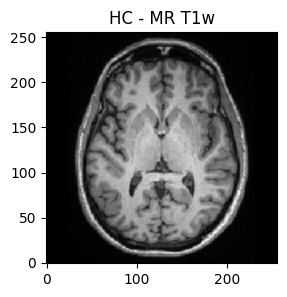

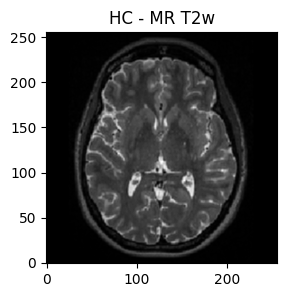

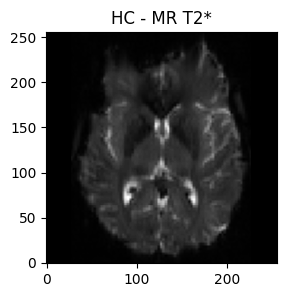

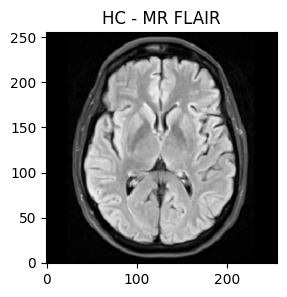

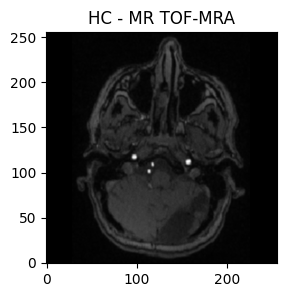

In [72]:
dataiter = iter(val_loader)
batch_sample = next(dataiter)
labels = batch_sample["label"]

for modality in modality_names:
    images = batch_sample[modality]
    classes = ["HC", "AD"]

    plt.figure(figsize=(3, 3))
    i = 0
    for sample_data, sample_label in zip(images, labels):
        sample = sample_data.cpu()[0]
        plt.subplot(1, batch_size, i+1)  # Create a subplot for each sample
        plt.imshow(sample.T, cmap='gray', origin='lower')
        plt.title(f"{classes[int(sample_label.cpu())]} - {modality}")  # Display the label as the title
        i += 1
plt.show()

### Load unimodal classification models

In [95]:
model_paths = {
    "MR T1w": "pretrained/DenseNet121_ad_cls_oasis_3_MR_T1.pth",
    "MR T2w": "pretrained/DenseNet121_ad_cls_oasis_3_MR_T2.pth",
    "MR T2*": "pretrained/DenseNet121_ad_cls_oasis_3_MR_T2_STAR.pth",
    "MR FLAIR": "pretrained/DenseNet121_ad_cls_oasis_3_MR_FLAIR.pth",
    "MR TOF-MRA": "pretrained/DenseNet121_ad_cls_oasis_3_MR_TOF_MRA.pth"
}
models = {}
for modality in modality_names:
    model = DenseNet121(spatial_dims=2, in_channels=1, out_channels=1)
    model.load_state_dict(torch.load(model_paths[modality], map_location=device))
    model.to(device=device)
    models[modality] = model

auc_metric_prod = ROCAUCMetric()
auc_metric_max = ROCAUCMetric()

### Training

In [96]:
y_pred_trans = Compose([Activations(sigmoid=True)])


for mod, model in models.items():
    model.eval()

with torch.no_grad():
    y_pred_product = torch.tensor([], dtype=torch.float32, device=device)
    y_pred_max = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    i = 0
    for val_data in val_loader:
        print(i)
        i += 1

        y_pred_product_sample = 1
        y_pred_max_sample = 0
        for modality in modality_names:
            if not val_data["has " + modality]:
                continue
            
            model = models[modality]
            val_images = val_data[modality].to(device)
            pred = y_pred_trans(decollate_batch(model(val_images)))
            print(pred)
            y_pred_product_sample *= pred[0]
            y_pred_max_sample = max(y_pred_max_sample, pred[0])

        val_labels = val_data["label"].to(device)
        y_pred_product = torch.cat([y_pred_product, y_pred_product_sample], dim=0)
        y_pred_max = torch.cat([y_pred_max, y_pred_max_sample], dim=0)

        y = torch.cat([y, val_labels], dim=0)

    y_onehot = y.cpu()

    auc_metric_prod(y_pred_product.cpu(), y_onehot)
    result_prod = auc_metric_prod.aggregate()

    auc_metric_max(y_pred_max.cpu(), y_onehot)
    result_max = auc_metric_max.aggregate()

    print(f"Product Fusion AUC = {result_prod}")
    print(f"Max Fusion AUC = {result_max}")

0
[metatensor([0.0247], device='cuda:0')]
[metatensor([0.1766], device='cuda:0')]
[metatensor([0.0416], device='cuda:0')]
1
[metatensor([0.0369], device='cuda:0')]
[metatensor([0.1985], device='cuda:0')]
2
[metatensor([0.1889], device='cuda:0')]
[metatensor([0.0925], device='cuda:0')]
[metatensor([0.6920], device='cuda:0')]
3
[metatensor([0.0178], device='cuda:0')]
[metatensor([0.1388], device='cuda:0')]
4
[metatensor([0.9761], device='cuda:0')]
[metatensor([0.5537], device='cuda:0')]
[metatensor([0.9822], device='cuda:0')]
[metatensor([0.2166], device='cuda:0')]
5
[metatensor([0.0298], device='cuda:0')]
[metatensor([0.0667], device='cuda:0')]
[metatensor([0.0095], device='cuda:0')]
6
[metatensor([0.9728], device='cuda:0')]
[metatensor([0.2368], device='cuda:0')]
[metatensor([0.4848], device='cuda:0')]
7
[metatensor([0.0111], device='cuda:0')]
[metatensor([0.0853], device='cuda:0')]
8
[metatensor([0.0141], device='cuda:0')]
[metatensor([0.1957], device='cuda:0')]
[metatensor([0.0588], 